## 脏页速率 + 带宽

虚拟机规格:
* 16核，320G内存
* 带宽: 100G
* multifd-channel: 12
* dirty page产生方式: 使用 peterxu 的 mig_mon(mm_dirty), 启动10个线程，每个线程在30G内存
  区域中做访存

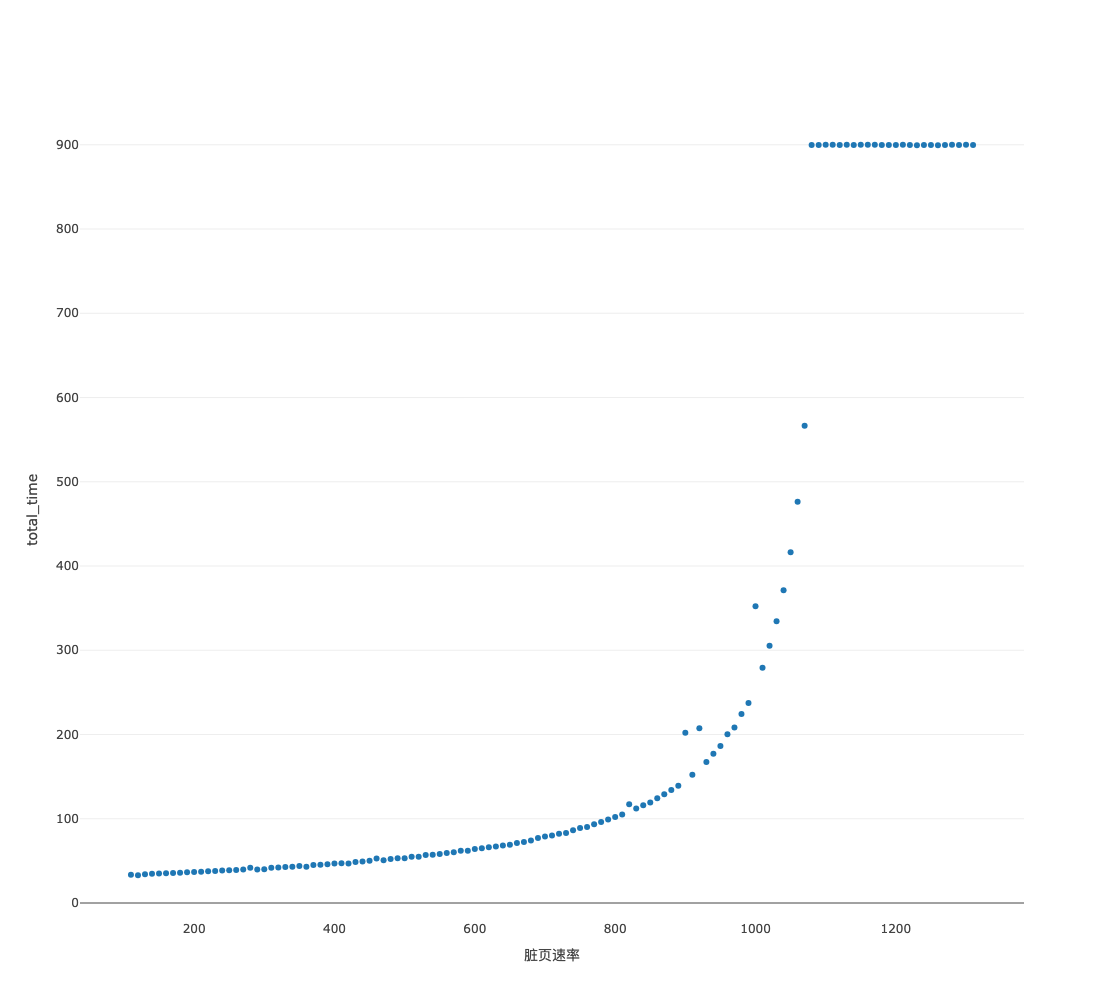

In [2]:
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import re

import json
import os
from pathlib import Path
import re

class ProgressHistory:
    def __init__(self, json_file):
        self.json_file = json_file
        self.progress_history = self.load_json()

    def load_json(self):
        """从 JSON 文件加载数据"""
        with open(self.json_file, 'r') as file:
            return json.load(file)

    def extract_raminfo_one(self, entry_name):
        info_arr = []
        for entry in self.progress_history.get('progress_history', []):
            ram_info = entry.get('ram', {})
            ram_info_one = ram_info.get(entry_name)
            info_arr.append(ram_info_one)
        return info_arr

    def extract_info_one(self, entry_name):
        info_arr = []
        for entry in self.progress_history.get('progress_history', []):
            info = entry.get(entry_name, {})
            info_arr.append(info)
        return info_arr
    def get_total_time(self):
        info_time = self.extract_info_one('now')
        total_time = info_time[-1] - info_time[0]
        return total_time

class LogFileExplorer:
    def __init__(self, log_dir):
        self.log_dir = Path(log_dir)

    def get_total_time(self, file_path):
        progress = ProgressHistory(file_path)
        total_time = progress.get_total_time()

        return total_time
    def get_rate_from_file_name(self, filename):
        match = re.search(r'rate_(\d+)_mc_', filename)
        return match.group(1)

    def stat_total_time(self):
        stat = []
        for file in self.log_dir.rglob('*'):  # 使用 rglob('*') 遍历所有文件
            if file.is_file():  # 确保是文件
                filepath = os.path.join(self.log_dir, file.name)
                total_time = self.get_total_time(filepath)
                rate = self.get_rate_from_file_name(file.name)
                stat.append([rate, total_time])
        return stat

explore = LogFileExplorer('log_dir/320G_test1/guestperf_dir/')
stat = explore.stat_total_time()

sorted_array = sorted(stat, key=lambda x: (x[0], x[1]))

rate_list = [subarray[0] for subarray in sorted_array]
total_time = [subarray[1] for subarray in sorted_array]

info_stat = go.Scatter(
        x=rate_list,  
        y=total_time, 
        # 散点 + 线段绘图
        mode="markers",  
        name="rate total_time",
    )
fig = go.Figure(
            layout={
                "template": "xgridoff",
                "yaxis": {
                    # 旋转坐标字体
                    "tickangle": 0,
                    "autorange": True,
                    "tickformat": '.0f',
                    "title": "total_time",
                },
                "xaxis": {
                    # 旋转坐标字体
                    "tickangle": 0,
                    "autorange": True,
                    "tickformat": '.0f',
                    "title": "脏页速率",
                },
                "height": 1000,    
            }
        )
fig.add_trace(info_stat)
fig.show()